In [1]:
import matplotlib
import math as mt
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import odeint, solve_ivp
from json import loads, dumps


In [2]:
def calc_ws( gamma_wat: float) -> float:
    
    """
    Функция для расчета солесодержания в воде

    :param gamma_wat: относительная плотность по пресной воде с плотностью 1000 кг/м3, безразм.

    :return: солесодержание в воде, г/г
    """
    
    ws = (
            1 / (gamma_wat * 1000)
            * (1.36545 * gamma_wat * 1000 - (3838.77 * gamma_wat * 1000 - 2.009 * (gamma_wat * 1000) ** 2) ** 0.5)
    )
    # если значение отрицательное, значит скорее всего плотность ниже допустимой 992 кг/м3
    if ws > 0:
        return ws
    else:
        return 0


def calc_rho_w( ws: float, t: float) -> float:

    """
    Функция для расчета плотности воды в зависимости от температуры и солесодержания

    :param ws: солесодержание воды, г/г
    :param t: температура, К

    :return: плотность воды, кг/м3
    """
    
    rho_w = (1000 * (1.0009 - 0.7114 * ws + 0.2605 * ws ** 2) ** (-1))/(1 + (t - 273) * 1e-4 * (0.269 * (t - 273) ** 0.637 - 0.8))

    return rho_w 

def calc_mu_w( ws: float, t: float, p: float) -> float:
    
    a = (
            109.574
            - (0.840564 * 1000 * ws)
            + (3.13314 * 1000 * ws ** 2)
            + (8.72213 * 1000 * ws ** 3)
    )
    b = (
            1.12166
            - 2.63951 * ws
            + 6.79461 * ws ** 2
            + 54.7119 * ws ** 3
            - 155.586 * ws ** 4
    )

    mu_w = (
            a * (1.8 * t - 460) ** (-b)
            * (0.9994 + 0.0058 * (p * 1e-6) + 0.6534 * 1e-4 * (p * 1e-6) ** 2)
    )
    return mu_w


def calc_n_re( rho_w: float, q_ms: float, mu_w: float, d_tub: float) -> float:
    v = q_ms / (np.pi * d_tub ** 2 / 4)
    n_re = rho_w * v * d_tub / mu_w * 1000
    
    return n_re


def calc_ff_churchill(n_re: float, roughness: float, d_tub: float) -> float:
        
    a = (-2.457 * np.log((7 / n_re) ** 0.9 + 0.27 * (roughness / d_tub))) ** 16
    b = (37530 / n_re) ** 16

    ff = 8 * ((8 / n_re) ** 12 + 1 / (a + b) ** 1.5) ** (1/12)
    return ff


def calc_ff_churchill(n_re: float, roughness: float, d_tub: float) -> float:

    a = (-2.457 * np.log((7 / n_re) ** 0.9 + 0.27 * (roughness / d_tub))) ** 16
    b = (37530 / n_re) ** 16

    ff = 8 * ((8 / n_re) ** 12 + 1 / (a + b) ** 1.5) ** (1/12)
    return ff

def calc_ff_jain(n_re: float, roughness: float, d_tub: float) -> float:

    if n_re < 3000:
        ff = 64 / n_re
    else:
        ff = 1 / (1.14 - 2 * np.log10(roughness / d_tub + 21.25 / (n_re**0.9))) ** 2
    return ff



In [3]:

def calc_dp_dl_grav(rho_w: float, angle: float):
    dp_dl_grav = rho_w * 9.81 * np.sin(angle / 180 * np.pi)
    return dp_dl_grav

def calc_dp_dl_fric( rho_w: float, mu_w: float, q_ms: float, d_tub: float, roughness: float):
    
    if q_ms != 0:
        n_re = calc_n_re(rho_w, q_ms, mu_w, d_tub)
        ff = calc_ff_churchill(n_re, roughness, d_tub)
        dp_dl_fric = ff * rho_w * q_ms ** 2 / d_tub ** 5
    else:
        dp_dl_fric = 0
    return dp_dl_fric

def calc_dp_dl( rho_w: float, mu_w: float, angle: float, q_ms: float, d_tub: float, roughness: float) -> float:

    dp_dl_grav = calc_dp_dl_grav(rho_w, angle)

    dp_dl_fric = calc_dp_dl_fric(rho_w, mu_w, q_ms, d_tub, roughness)

    dp_dl = dp_dl_grav - 0.815 * dp_dl_fric

    return dp_dl


[273.         276.26160687 279.52321373 282.7848206  286.04642746
 289.30803433 292.56964119 295.83124806 299.09285493 302.35446179
 305.61606866 308.87767552 312.13928239 315.40088925 318.66249612
 321.92410299 325.18570985 328.44731672 331.70892358 334.97053045
 338.23213731 341.49374418 344.75535104 348.01695791 351.27856478
 354.54017164 357.80177851 361.06338537 364.32499224 367.5865991 ]
[1005.57117603 1005.64621431 1005.51325224 1005.22682192 1004.80900493
 1004.27340544 1003.62968243 1002.88525433 1002.0461158  1001.11728761
 1000.10308857  999.00731115  997.83334086  996.58424059  995.26281211
  993.87164223  992.41313804  990.88955445  989.30301597  987.65553428
  985.9490224   984.18530648  982.36613547  980.49318926  978.56808551
  976.59238552  974.56759915  972.49518911  970.37657465  968.21313475]


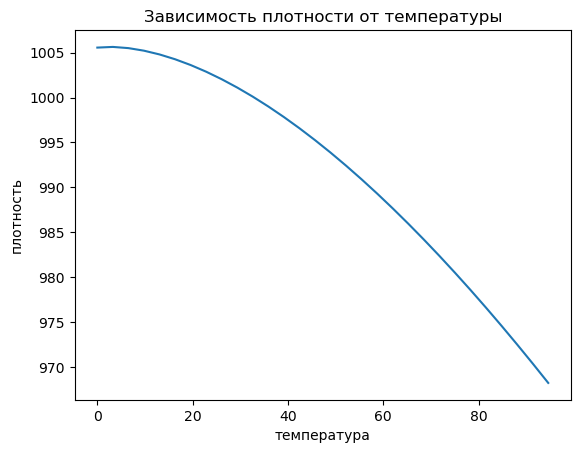

In [4]:
temp_grad = 2.2827422270429416
t1 = temp_grad * 30 + 26.104332293188772
n = 30
tt = np.linspace(273, t1+273, n)
print (tt)

rho_w = calc_rho_w(calc_ws (0.9974119149798719), tt)
print(rho_w)

# задание массива значений для построения графика
plt.plot(tt-273, [calc_rho_w(calc_ws (0.9974119149798719), t) for t in tt])
plt.title('Зависимость плотности от температуры')
plt.xlabel('температура')
plt.ylabel('плотность')
plt.show()

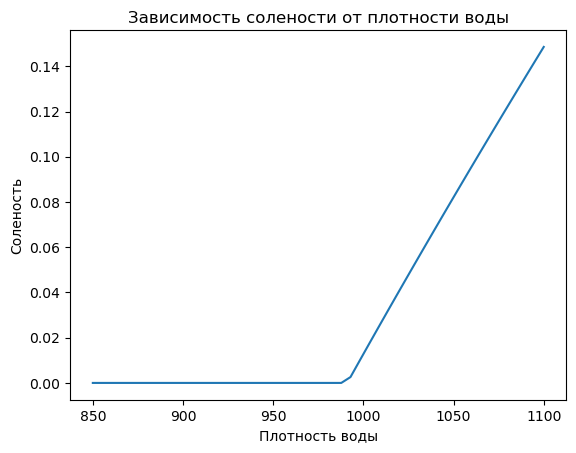

In [5]:
x = np.linspace(850, 1100, 50)                          
plt.plot(x, [calc_ws(gamma_wat/1000) for gamma_wat in x])
plt.title('Зависимость солености от плотности воды')
plt.xlabel("Плотность воды")
plt.ylabel("Соленость")
plt.show()

# В функция calc_ws есть заметка, что если плотность = 992, то calc_ws = 0 -> график начинается с полки на 0


[ 0.          3.26160687  6.52321373  9.7848206  13.04642746 16.30803433
 19.56964119 22.83124806 26.09285493 29.35446179 32.61606866 35.87767552
 39.13928239 42.40088925 45.66249612 48.92410299 52.18570985 55.44731672
 58.70892358 61.97053045 65.23213731 68.49374418 71.75535104 75.01695791
 78.27856478 81.54017164 84.80177851 88.06338537 91.32499224 94.5865991 ]


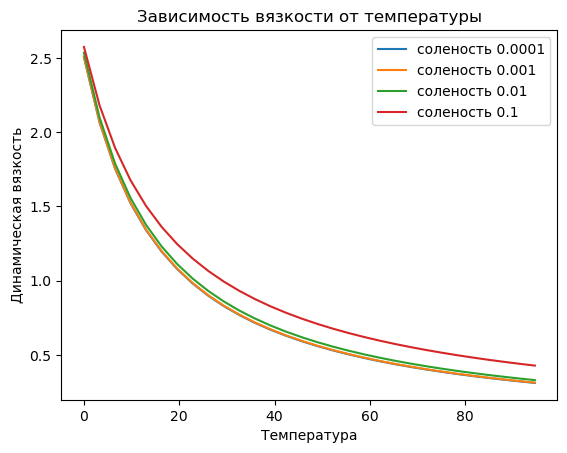

In [6]:
temp_grad = 2.2827422270429416
t1 = temp_grad * 30 + 26.104332293188772
n = 30
tt = np.linspace(273, t1+273, n)
print (tt-273)


plt.plot(tt-273, [calc_mu_w(0.0001, t, 13780200) for t in tt], label = "соленость 0.0001")
plt.plot(tt-273, [calc_mu_w(0.001, t, 13780200) for t in tt], label = "соленость 0.001")
plt.plot(tt-273, [calc_mu_w(0.01, t, 13780200) for t in tt], label = "соленость 0.01")
plt.plot(tt-273, [calc_mu_w(0.1, t, 13780200) for t in tt], label = "соленость 0.1")
plt.title('Зависимость вязкости от температуры')
plt.xlabel("Температура")
plt.ylabel("Динамическая вязкость")
plt.legend()
plt.show()

In [7]:
print (calc_ws (0.9974119149798719))
print (calc_rho_w(0.009083219722503528, 299.25))
print (calc_mu_w(calc_ws (0.9974119149798719), 299.25, 13780200))

print (calc_n_re(1002.0033841449284, 0.00463, 0.9237751763308781, 0.06591752424146266)) # дебит 400 м3/сут
print (calc_n_re(1002.0033841449284, 0.0012, 0.9237751763308781, 0.06591752424146266)) # дебит 100 м3/сут

0.009083219722503528
1002.0033841449284
0.9237751763308781
97004.77723386737
25141.626928864112


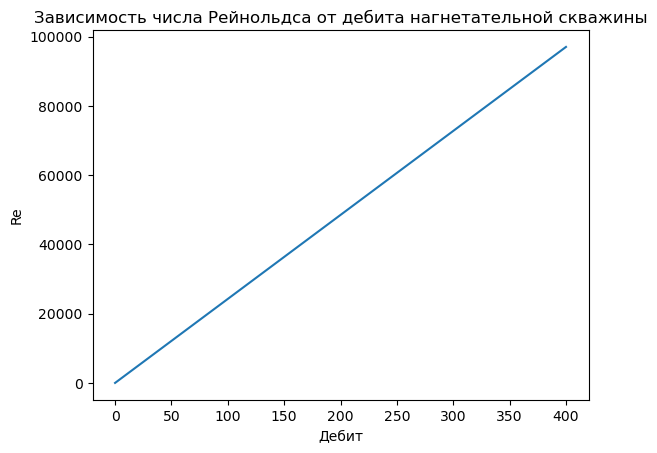

In [8]:
x = np.linspace(0, 400, 50)
plt.plot(x, [calc_n_re(rho_w=1002.0033841449284, q_ms=t/86400, mu_w=0.9237751763308781, d_tub=0.06591752424146266) for t in x])
plt.title('Зависимость числа Рейнольдса от дебита нагнетательной скважины')
plt.xlabel("Дебит")
plt.ylabel("Re")
plt.show()

C:\Users\kache\AppData\Local\Temp\ipykernel_2492\262106561.py:78: RuntimeWarning: divide by zero encountered in scalar divide
  a = (-2.457 * np.log((7 / n_re) ** 0.9 + 0.27 * (roughness / d_tub))) ** 16
C:\Users\kache\AppData\Local\Temp\ipykernel_2492\262106561.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  b = (37530 / n_re) ** 16
C:\Users\kache\AppData\Local\Temp\ipykernel_2492\262106561.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  ff = 8 * ((8 / n_re) ** 12 + 1 / (a + b) ** 1.5) ** (1/12)
C:\Users\kache\AppData\Local\Temp\ipykernel_2492\262106561.py:87: RuntimeWarning: divide by zero encountered in scalar divide
  ff = 64 / n_re


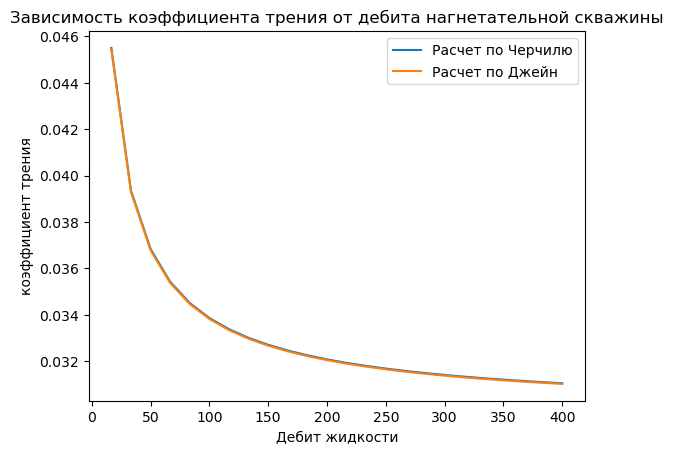

In [9]:
x = np.linspace(0, 400, 25)
n_re_list = [calc_n_re(rho_w=1002.0033841449284, q_ms=t/86400, mu_w=0.9237751763308781, d_tub=0.06591752424146266) for t in x]

plt.plot(x, [calc_ff_churchill(t, 0.0003091727046321148, 0.06591752424146266) for t in n_re_list], label ="Расчет по Черчилю")
plt.plot(x, [calc_ff_jain(t, 0.0003091727046321148, 0.06591752424146266) for t in n_re_list], label ="Расчет по Джейн")
plt.title('Зависимость коэффициента трения от дебита нагнетательной скважины')
plt.xlabel("Дебит жидкости")
plt.ylabel("коэффициент трения")
plt.legend()
plt.show()

C:\Users\kache\AppData\Local\Temp\ipykernel_2492\262106561.py:78: RuntimeWarning: divide by zero encountered in scalar divide
  a = (-2.457 * np.log((7 / n_re) ** 0.9 + 0.27 * (roughness / d_tub))) ** 16
C:\Users\kache\AppData\Local\Temp\ipykernel_2492\262106561.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  b = (37530 / n_re) ** 16
C:\Users\kache\AppData\Local\Temp\ipykernel_2492\262106561.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  ff = 8 * ((8 / n_re) ** 12 + 1 / (a + b) ** 1.5) ** (1/12)
C:\Users\kache\AppData\Local\Temp\ipykernel_2492\262106561.py:87: RuntimeWarning: divide by zero encountered in scalar divide
  ff = 64 / n_re


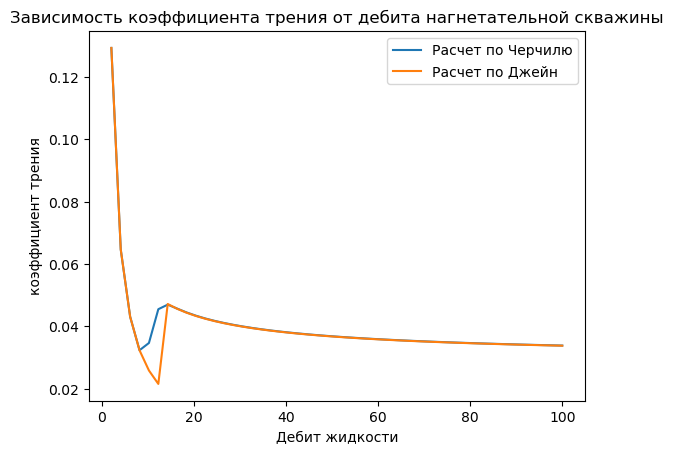

In [10]:
x = np.linspace(0, 100, 50)
n_re_list = [calc_n_re(rho_w=1002.0033841449284, q_ms=t/86400, mu_w=0.9237751763308781, d_tub=0.06591752424146266) for t in x]

plt.plot(x, [calc_ff_churchill(t, 0.0003091727046321148, 0.06591752424146266) for t in n_re_list], label ="Расчет по Черчилю")
plt.plot(x, [calc_ff_jain(t, 0.0003091727046321148, 0.06591752424146266) for t in n_re_list], label ="Расчет по Джейн")
plt.title('Зависимость коэффициента трения от дебита нагнетательной скважины')
plt.xlabel("Дебит жидкости")
plt.ylabel("коэффициент трения")
plt.legend()
plt.show()

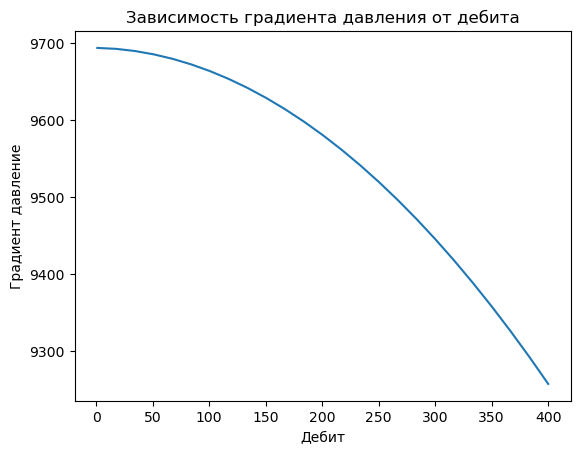

In [11]:
x = np.linspace(1, 400, 25)
plt.plot(x, [calc_dp_dl(rho_w=1002.0033841449284, mu_w=0.9237751763308781, angle=80.47848386669185, q_ms=t/86400, d_tub=0.06591752424146266, roughness=0.0003091727046321148) for t in x])
plt.title('Зависимость градиента давления от дебита')
plt.ylabel("Градиент давление")
plt.xlabel("Дебит")
plt.show()

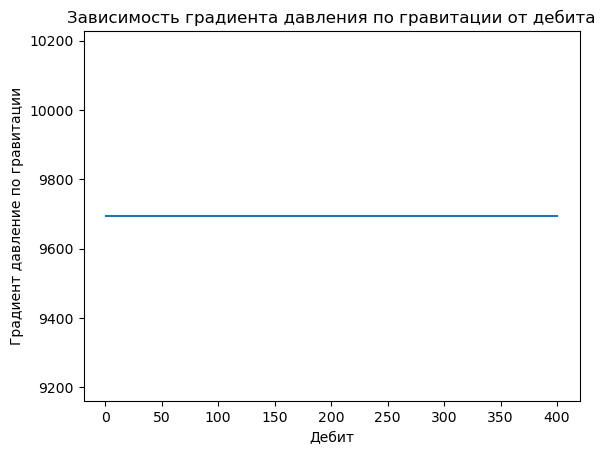

In [12]:
x = np.linspace(1, 400, 25)
plt.plot(x, [calc_dp_dl_grav(rho_w=1002.0033841449284, angle=80.47848386669185) for t in x])
plt.title('Зависимость градиента давления по гравитации от дебита')
plt.ylabel("Градиент давление по гравитации")
plt.xlabel("Дебит")
plt.show()

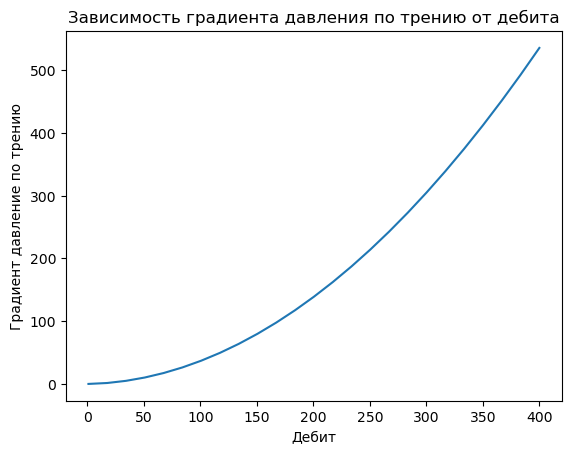

In [13]:
x = np.linspace(1, 400, 25)
plt.plot(x, [calc_dp_dl_fric(rho_w=1002.0033841449284, mu_w=0.9237751763308781, q_ms=t/86400, d_tub=0.06591752424146266, roughness=0.0003091727046321148) for t in x])
plt.title('Зависимость градиента давления по трению от дебита')
plt.ylabel("Градиент давление по трению")
plt.xlabel("Дебит")
plt.show()

Text(0.5, 0, 'Дебит')

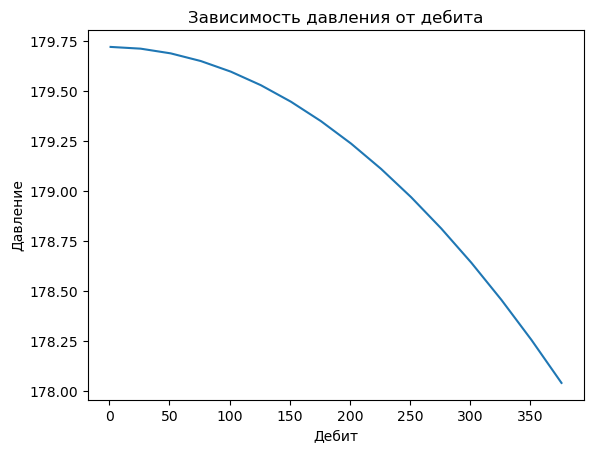

In [17]:
import json

data = {"gamma_water": 0.9974119149798719, "md_vdp": 2764.0549899214448, "d_tub": 0.06591752424146266, "angle": 80.47848386669185, "roughness": 0.0003091727046321148, "p_wh": 136.05798700778203, "t_wh": 26.104332293188772, "temp_grad": 2.2827422270429416}

def integr_func( h: float, pt: tuple, temp_grad: float, gamma_wat: float, angle: float, q_ms: float, d_tub: float, roughness: float ) -> tuple:
   
    return calc_dp_dl(calc_rho_w(calc_ws(gamma_wat), pt[1]), calc_mu_w(calc_ws(gamma_wat), pt[1], pt[0]), angle, q_ms, d_tub, roughness), temp_grad


def calc_pipe( p_wh: float, t_wh: float, h0: float, md_vdp: float, temp_grad: float, gamma_wat: float, angle: float, q_ms: float, d_tub: float, roughness: float ) -> tuple:

    num_of_steps = 1000 
    step_size = (md_vdp - h0) / num_of_steps

    p = [p_wh]
    t = [t_wh]

    depths = np.linspace(h0, md_vdp, num_of_steps)
    
    #Метод Эйлера-Коши
    for i in range(len(depths) - 1):
        step_size = depths[i + 1] - depths[i]
        
        #dp_i/dx_i
        grad_p, grad_t = integr_func(depths[i], (p[-1], t[-1]), temp_grad, gamma_wat, angle, q_ms, d_tub, roughness)
        #dp_i+1 с волной / dx_i+1
        grad_pp, grad_tt = integr_func(depths[i + 1], (p[-1] + grad_p * step_size, t[-1] + grad_t * step_size), temp_grad, gamma_wat, angle, q_ms, d_tub, roughness)
        
        p.append(p[-1] + (grad_p + grad_pp) / 2 * step_size)
        t.append(t[-1] + (grad_t + grad_tt) / 2 * step_size)
    
    return p, t


def calc_p_wf(p_wh: float, t_wh: float, h0: float, md_vdp: float, temp_grad: float, gamma_wat: float, angle: float, q_ms: float, d_tub: float, roughness: float ) -> float:

    p = calc_pipe(p_wh, t_wh, h0, md_vdp, temp_grad, gamma_wat, angle, q_ms, d_tub, roughness)[0]

    return p[-1]


Q = []
for t in range(1, 400, 25):
    Q.append(t)

gamma_water = data['gamma_water']
H = data['md_vdp']
d_tub = data['d_tub']
angle = data['angle']
roughness = data['roughness']
p_wh = data['p_wh'] * 101325 
t_wh = data['t_wh'] + 273 
temp_grad = data['temp_grad']

P = []

for q in Q:
        q_ms = q / 86400 
        p_wf = calc_p_wf(p_wh, t_wh, 0, H, temp_grad, gamma_water, angle, q_ms, d_tub, roughness) / 101325
        P.append(p_wf)
        data_export = {
            "q_liq": Q,
            "p_wf": P
        }

with open('output.json', 'w') as json_file:
    json.dump(data_export, json_file, indent=4)


plt.plot(Q, P)
plt.title("Зависимость давления от дебита")
plt.ylabel("Давление")
plt.xlabel("Дебит")

